# Optimization in SciPy

Optimization seeks to find the best (optimal) value of some function subject to constraints

\begin{equation}
\mathop{\mathsf{minimize}}_x f(x)\\
\text{subject to } c(x) \le b
\end{equation}

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import scipy.optimize as opt

## Functions of One Variable

An easy example is to minimze a quadratic

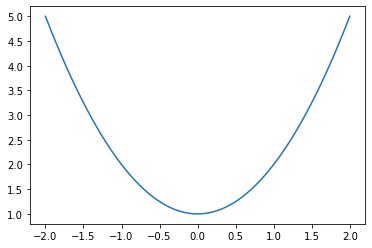

In [4]:
f = lambda x: x**2 + 1 # a x^T x + 0*x + 1

x = np.linspace(-2,2,500)
plt.plot(x, f(x))
plt.show()

There is a clear minimum at `x = 0`.  You can search for minima using [`opt.minimize_scalar`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar)

In [5]:
sol = opt.minimize_scalar(f)
sol

     fun: 1.0
    nfev: 40
     nit: 36
 success: True
       x: 9.803862664247969e-09

The return type gives you the function value `sol.fun`, as well as the value of `x` which achieve the minimum `sol.x`

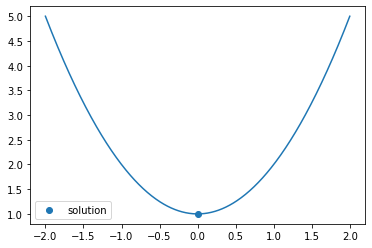

In [6]:
x = np.linspace(-2,2,500)
plt.plot(x, f(x))
plt.scatter([sol.x], [sol.fun], label='solution')
plt.legend()
plt.show()

If you want to add constraints such as $x \ge 1$, you can use `bounds`, along with specifying the `bounded` method:

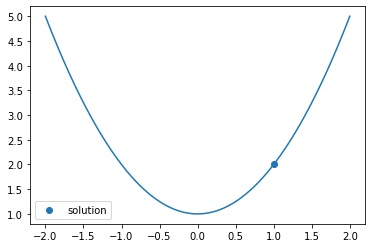

In [9]:
sol = opt.minimize_scalar(f, bounds=(1, 1000), method='bounded')
x = np.linspace(-2,2,500)
plt.plot(x, f(x))
plt.scatter([sol.x], [sol.fun], label='solution')
plt.legend()
plt.show()

For more complicated functions, there may be multiple solutions

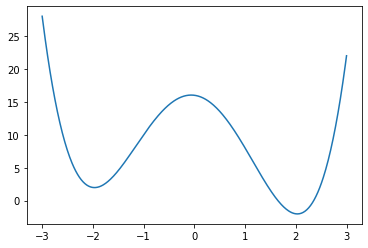

In [16]:
f = lambda x : (x - 2)**2 * (x + 2)**2 - x

x = np.linspace(-3,3,500)
plt.plot(x, f(x))
plt.show()

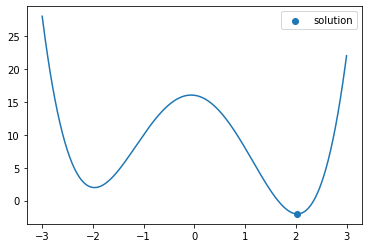

In [17]:
sol = opt.minimize_scalar(f)

plt.plot(x, f(x))
plt.scatter([sol.x], [sol.fun], label='solution')
plt.legend()
plt.show()

Note that you will only find one minimum, and this minimum will generally only be a local minimum, not a global minimum.

## Functions of Multiple variables

You might also wish to minimize functions of multiple variables.  In this case, you use [`opt.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)

A multivariate quadratic generally has the form `x^T A x + b^T x + c`, where `x` is an `n`-dimensional vector, `A` is a `n` x `n` matrix, `b` is a `n`-dimensional vector, and `c` is a scalar.  When `A` is positive definite (PD), there is a unique minimum.

In [18]:
n = 2
A = np.random.randn(n+1,n)
A = A.T @ A # generates positive-definite matrix

b = np.random.rand(n)

f = lambda x : np.dot(x - b, A @ (x - b)) # (x - b)^T A (x - b)

sol = opt.minimize(f, np.zeros(n))
sol

      fun: 4.729999012197495e-14
 hess_inv: array([[ 0.14300472, -0.09112081],
       [-0.09112081,  0.3217534 ]])
      jac: array([9.61981404e-07, 2.13666532e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([0.82257493, 0.10186801])

The solution for the above problem is `x = b`

In [19]:
print(sol.x)
print(b)
print(np.linalg.norm(sol.x - b))

[0.82257493 0.10186801]
[0.82257482 0.10186803]
1.1208237699941506e-07


We can increase the dimension of the problem to be much greater:

In [20]:
n = 100
A = np.random.randn(n+1,n)
A = A.T @ A

b = np.random.rand(n)

f = lambda x : np.dot(x - b, A @ (x - b)) # (x - b)^T A (x - b)

sol = opt.minimize(f, np.zeros(n))

print(la.norm(sol.x - b))

1.3924832374070244e-05


### Example: Solving a Linear System

Recall that solving a linear system means finding $x$ so that $A x = b$. We can turn this into an optimization problem by seeking to minimize the residual $\|b - Ax\|_2$:
\begin{equation}
\mathop{\mathsf{minimize}}_x \|b - Ax\|_2\\
\end{equation}

In [24]:
n = 5
A = np.random.randn(n,n)
x0 = np.random.randn(n) # ground truth x
b = A @ x0

sol = opt.minimize(lambda x : la.norm(b - A @ x), np.zeros(n))
la.norm(sol.x - x0)

9.475554894067411e-08

### Exercises

1. Modify the above example to minimize $\|b-Ax\|_1$ instead of $\| b - Ax\|_2$ (look at documentation for `la.norm`).  Is there any difference in the output of `opt.minimize`?

2. How fast is `la.solve` compared to the above example?

In [ ]:
## Your code here


## Constraints

Passing in a function to be optimized is fairly straightforward.  Constraints are slightly less trivial.  These are specified using classes [`LinearConstraint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.LinearConstraint.html#scipy.optimize.LinearConstraint) and [`NonlinearConstraint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.NonlinearConstraint.html#scipy.optimize.NonlinearConstraint)

* Linear constraints take the form `lb <= A @ x <= ub`
* Nonlinear constraints take the form `lb <= fun(x) <= ub`

For the special case of a linear constraint with the form `lb <= x <= ub`, you can use [`Bounds`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.Bounds.html#scipy.optimize.Bounds)

### Linear Constraints

Let's look at how you might implement the linear constraints on a 2-vector x
\begin{equation}
\begin{cases}
-1 \le x_0 \le 1\\
c \le A * x \le d
\end{cases}
\end{equation}
where `A = np.array([[1,1],[0, 1]]`, `c = -2 * np.ones(2)`, and `d = 2 * np.ones(2)`

In [26]:
from scipy.optimize import Bounds, LinearConstraint

# constraint 1
C1 = Bounds(np.array([-1, -np.inf]), np.array([1,np.inf]))

# constraint 2
A = np.array([[1,1],[0,1]])
c = -2 * np.ones(2)
d = 2 * np.ones(2)
C2 = LinearConstraint(A, c, d)

here's a visualization of the constrained region:

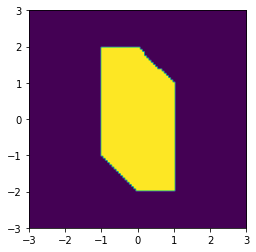

In [27]:
n = 100
xx, yy = np.meshgrid(np.linspace(-3,3,n), np.linspace(-3,3,n))

C = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        x = np.array([xx[i,j], yy[i,j]])
        # constraint 1 
        c1 = -1 <= xx[i,j] <= 1
        # constraint 2
        c2 = np.all((c <= A@x, A@x <= d))
        C[i,j] = c1 and c2
        
plt.imshow(C, extent=(-3,3,-3,3), origin='lower')
plt.show()

Now, let's say we want to minimize a function `f(x)` subject to `x` obeying the constraints given above.  We can simply pass in the constraints

In [28]:
f = lambda x : x[0]*x[1]
sol = opt.minimize(f, np.random.rand(2), bounds=C1, constraints=(C2,))
sol

     fun: -1.9999999972109852
     jac: array([ 2., -1.])
 message: 'Optimization terminated successfully'
    nfev: 18
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([-1.,  2.])

Let's visualize the function in the constrained region:

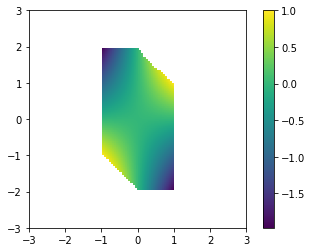

In [29]:
F = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if C[i,j]:
            F[i,j] = f([xx[i,j], yy[i,j]])
        else:
            F[i,j] = np.nan
            
plt.imshow(F, extent=(-3,3,-3,3), origin='lower')
plt.colorbar()
plt.show()

We see that `[-1,2]` does appear to be a minimum

### Nonlinear constraints

Nonlinear constraints can be used to define more complicated domains.  For instance, let's look at the constraint
\begin{equation}
1 \le \| x \|_2 \le 2
\end{equation}

In [30]:
from scipy.optimize import NonlinearConstraint

C3 = NonlinearConstraint(lambda x : np.linalg.norm(x), 1, 2)

we can visualize this constraint again, and we see that it defines an annulus

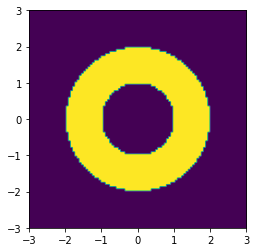

In [31]:
n = 100
xx, yy = np.meshgrid(np.linspace(-3,3,n), np.linspace(-3,3,n))

C = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        x = np.array([xx[i,j], yy[i,j]])
        C[i,j] = 1 <= np.linalg.norm(x) <= 2
        
plt.imshow(C, extent=(-3,3,-3,3), origin='lower')
plt.show()

Let's try minimizing the same function as before: $f(x) = x[0] * x[1]$

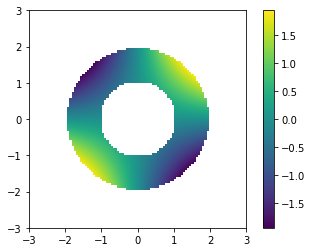

In [32]:
f = lambda x : x[0]*x[1]

F = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if C[i,j]:
            F[i,j] = f([xx[i,j], yy[i,j]])
        else:
            F[i,j] = np.nan
            
plt.imshow(F, extent=(-3,3,-3,3), origin='lower')
plt.colorbar()
plt.show()

In [33]:
sol = opt.minimize(f, np.random.rand(2), constraints=(C3,))
sol

     fun: -2.0000000022045694
     jac: array([-1.41422868,  1.41419846])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 1.41419846, -1.41422867])

we see that the solution is close to a true minimizer $x = [-\sqrt{2}, \sqrt{2}]$

### Example: Eigenvalues and Eigenvectors

One example of an optimzation problem is to find the largest eigenvalue/eigenvector pair of a matrix $A$.  If $A$ is symmetric, and $(\lambda, x)$ is the largest eigenvalue pair, then $x$ satisfies
\begin{equation}
\mathop{\mathsf{minimize}}_x -x^T A x\\
\text{subject to } \|x\|_2 = 1
\end{equation}

And we have $x^T A x = \lambda$.  Let's try encoding this as an optimization problem.

In [34]:
n = 5
A = np.random.randn(n,n)
A = A + A.T # make symmetric

NormConst = NonlinearConstraint(lambda x : np.linalg.norm(x), 1, 1) # norm constraint
sol = opt.minimize(lambda x : -np.dot(x, A @ x), np.random.randn(5), constraints=(NormConst, ))
sol

     fun: -5.7435430955451405
     jac: array([ 6.31214488, -0.50656259,  3.4018153 ,  8.38619447, -3.15480107])
 message: 'Optimization terminated successfully'
    nfev: 240
     nit: 37
    njev: 37
  status: 0
 success: True
       x: array([-0.54944695,  0.04439907, -0.29603503, -0.73003737,  0.27485555])

Let's take a look at a solution obtained using `eigh`:

In [35]:
import scipy.linalg as la
lam, V = la.eigh(A)
lam[-1], V[:,-1] # largest eigenpair

(5.743543245379755,
 array([ 0.54949231, -0.04411165,  0.29603039,  0.73008117, -0.27469958]))

In [39]:
print("error in eigenvalue: {}".format(lam[-1] + sol.fun))
print("error in eigenvector: {}".format(la.norm(-sol.x - V[:,-1])))

error in eigenvalue: 1.4983461404938225e-07
error in eigenvector: 0.00033306876713811573


## Optimization Options

So far, we haven't worried too much about the internals of `opt.minimize`.  However, for large problems, you're often going to want to choose an appropriate solver, and provide Jacobian and Hessian information if you are able to.

A list of available solvers is available [in the `minimize` documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html#local-multivariate-optimization).

### Jacobian

The [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) of a multi-valued function $f: \mathbb{R}^n \to \mathbb{R}^m$ is the $m\times n$ matrix $J_f$, where 
\begin{equation}
J_f[i,j] = \frac{\partial{f}_i}{\partial{x_j}}
\end{equation}

If $f$ is scalar-valued (i.e. $m = 1$), then the Jacobian is the transpose of the gradient $J_f = (\nabla f)^T$

In our examples so far, we only provided the function.  If you are able to provide the Jacobian as well, then you can typically solve problems with fewer function evaluations because you have better information about how to decrease the function value.  If you don't provide the Jacobian, many solvers will try to approximate the Jacobian using finite difference approximations, but these are typically less accurate (and slower) than if you can give an explicit formula.

Note that you can also provide a Jacobian to [`NonlinearConstraint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.NonlinearConstraint.html#scipy.optimize.NonlinearConstraint)

In [40]:
# function definition
def f(x):
    return np.cos(x[0]) + np.sin(x[1])

# Jacobian of function
def Jf(x):
    return np.array([-np.sin(x[0]), np.cos(x[1])])

x0 = np.random.rand(2)

%time sol1 = opt.minimize(f, x0)
sol1

CPU times: user 5.95 ms, sys: 1.01 ms, total: 6.96 ms
Wall time: 5.85 ms


      fun: -1.999999999999993
 hess_inv: array([[1.01014118, 0.00671505],
       [0.00671505, 1.00438537]])
      jac: array([1.04308128e-07, 5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 10
     njev: 11
   status: 0
  success: True
        x: array([ 3.14159276, -1.57079627])

In [41]:
%time sol2 = opt.minimize(f, x0, jac=Jf)
sol2

CPU times: user 4.06 ms, sys: 6 µs, total: 4.06 ms
Wall time: 3.03 ms


      fun: -1.9999999999999911
 hess_inv: array([[1.01014852, 0.00669782],
       [0.00669782, 1.00442045]])
      jac: array([1.11474852e-07, 7.35710258e-08])
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 10
     njev: 11
   status: 0
  success: True
        x: array([ 3.14159277, -1.57079625])

We see that when we provoide the Jacobian, the number of function evaluations `nfev` decreases.

### Hessian

The Hessian of a multivariate function $f: \mathbb{R}^n \to \mathbb{R}$ is a $n\times n$ matrix $H_f$ of second derivatives:
\begin{equation}
H[i,j] = \frac{\partial^2 f}{\partial x_i \partial x_j}
\end{equation}

The Hessian provides information about the *curvature* of the function $f$, which can be used to accelerate convergence of the optimization algorithm.  If you don't provide the Hessian, many solvers will numerically approximate it, which will typically not work as well as an explicit Hessian.

Again, you can also provide a Hessian to [`NonlinearConstraint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.NonlinearConstraint.html#scipy.optimize.NonlinearConstraint)

In [42]:
def Hf(x):
    return np.array([[-np.cos(x[0]), 0], [0, -np.sin(x[1])]])

%time sol3 = opt.minimize(f, x0, jac=Jf, hess=Hf)
sol3

CPU times: user 957 µs, sys: 2.94 ms, total: 3.9 ms
Wall time: 4.78 ms


/home/brad/miniconda3/envs/pycourse/lib/python3.8/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


      fun: -1.9999999999999911
 hess_inv: array([[1.01014852, 0.00669782],
       [0.00669782, 1.00442045]])
      jac: array([1.11474852e-07, 7.35710258e-08])
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 10
     njev: 11
   status: 0
  success: True
        x: array([ 3.14159277, -1.57079625])

We see that the defualt method `BFGS` does not use the Hessian.  Let's choose one that does, like [`Newton-CG`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-newtoncg.html).

In [43]:
def Hf(x):
    return np.array([[-np.cos(x[0]), 0], [0, -np.sin(x[1])]])

%time sol3 = opt.minimize(f, x0, jac=Jf, hess=Hf, method='Newton-CG')
sol3

CPU times: user 3.73 ms, sys: 37 µs, total: 3.76 ms
Wall time: 2.88 ms


     fun: -2.0
     jac: array([9.59646280e-07, 1.00039323e-06])
 message: 'Optimization terminated successfully.'
    nfev: 9
    nhev: 5
     nit: 5
    njev: 9
  status: 0
 success: True
       x: array([  9.42477796, -32.98672286])

In [44]:
(sol3.x - sol2.x)/np.pi

array([  1.99999996, -10.00000002])

As we see above, we only compute the function, Jacobian and Hessian for 5 iterations.  The wall time is about 5x as fast as when we didn't provide any of this additional information as well.  This will matter more for larger problems.

### Solvers

Here's a guide to a couple of different solvers.  See the [notes section of `minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) for additional details.


* Unconstrained minimization: [`BFGS`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) - uses Jacobian evaluations to get a low-rank approximation to the Hessian.
* Bound constrained minimization: [`L-BFGS-B`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html) - Variation of BFGS which uses limited memory (the `L`).  Use with very large problems.  Only uses Jacobian (not Hessian).
* Unconstrained minimization with Jacobian/Hessian: [`Newton-CG`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-newtoncg.html) - uses Jacobian and Hessian to exactly solve quadratic approximations to the objective.
* General constrained minimization: [`trust-const`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-trustconstr.html#optimize-minimize-trustconstr) - a trust region method for constrained optimization problems.  Can use the Hessian of both the objective and constraints.

You can find a lot of information and examples about these different options in the [`scipy.optimize` tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)

## Global Optimization

`opt.minimize` is good for finding local minima of functions.  This often works well when you have a single minimum, or if you don't care too much about finding the global minimum.

What if your function has many local minima, but you want to find the global minimum?  You can use one of the [global optimization functions](https://docs.scipy.org/doc/scipy/reference/optimize.html#global-optimization).

Note that finding a global minumum is generally a much more difficult problem than finding a local minimum, and these functions are not guranteed to find the true global minimum, and may not be very fast.

Here's an example of a function which has a global minimum, but many local minima:

In [61]:
# global minimum at (pi, -pi/2)
def f(x, a=0.1):
    return np.cos(x[0]) + np.sin(x[1]) + a*(x[0] - np.pi)**2 + a*(x[1] + np.pi/2)**2

In [62]:
f([np.pi, -np.pi/2])

-2.0

we can use the [`basinhopping`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html#scipy.optimize.basinhopping) solver to look for this minimum

In [63]:
sol = opt.basinhopping(f, 10*np.random.rand(2))
# sol = opt.basinhopping(f, np.array([np.pi, -np.pi/2]) + 0.2*np.random.randn(2))
sol

                        fun: 1.2144798903821434
 lowest_optimization_result:       fun: 1.2144798903821434
 hess_inv: array([[ 8.33183113e-01, -1.30339589e-03],
       [-1.30339589e-03,  2.53568455e+00]])
      jac: array([0.00000000e+00, 1.49011612e-08])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([3.14159265, 3.33549886])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 2124
                        nit: 100
                       njev: 708
                          x: array([3.14159265, 3.33549886])

as we see, we find a local minimum, but not the global minimum.  We can increase the number of basin-hopping iterations, and increase the "temperature" `T`, which governs the hop size to be the approximate distance between local minima.

In [71]:
%time sol = opt.basinhopping(f, 10*np.random.rand(2), T=1e-6, niter=1)
sol

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 10.2 ms


                        fun: 1.2144798903821465
 lowest_optimization_result:       fun: 1.2144798903821465
 hess_inv: array([[ 8.33590037e-01, -6.88823559e-04],
       [-6.88823559e-04,  2.54508510e+00]])
      jac: array([-4.47034836e-08,  2.98023224e-08])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([3.1415926 , 3.33549892])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 45
                        nit: 1
                       njev: 15
                          x: array([3.1415926 , 3.33549892])

Now, we get the true minimization value.

Here's the same problem using [`opt.dual_annealing`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.dual_annealing.html#scipy.optimize.dual_annealing):

In [54]:
%time sol = opt.dual_annealing(f, bounds=[[-100,100], [-100,100]])
sol

CPU times: user 378 ms, sys: 15.8 ms, total: 394 ms
Wall time: 420 ms


     fun: -1.9999999999999942
 message: ['Maximum number of iteration reached']
    nfev: 4031
    nhev: 0
     nit: 1000
    njev: 10
  status: 0
 success: True
       x: array([ 3.14159268, -1.57079623])

This runs much faster, and doesn't need as much tweaking of the arguments.  However, we had to specify bounds in which we would look for the solution.

## Finding Roots

A root of a function $f: \mathbb{R}^m \to \mathbb{R}^n$ is a point $x$ so that $f(x) = 0$.  The go-to function for this is [`opt.root`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html#scipy.optimize.root)

In [55]:
def f(x):
    return x + 2*np.cos(x)

sol = opt.root(f, np.random.rand())
print(sol.x, sol.fun) # root and value

[-1.02986653] [0.]


for scalar functions, you can also use [`root_scalar`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html#scipy.optimize.root_scalar)

In [56]:
sol = opt.root_scalar(f, x0=-1, x1=1)
sol.root

-1.0298665293222544

You can also find roots of multi-valued functions.  E.g. if we want to solve the nonlinear system
\begin{equation}
x_0 \cos(x_1) = 4\\
x_0 x_1 - x_1 = 5
\end{equation}

we can seek to find a root
\begin{equation}
x_0 \cos(x_1) - 4 = 0\\
x_0 x_1 - x_1 - 5 = 0
\end{equation}

In [57]:
def f(x):
    return [x[0] * np.cos(x[1]) - 4, x[1]*x[0] - x[1] - 5]

%time sol = opt.root(f, np.ones(2))
sol

CPU times: user 300 µs, sys: 0 ns, total: 300 µs
Wall time: 295 µs


    fjac: array([[-0.56248005, -0.82681085],
       [ 0.82681085, -0.56248005]])
     fun: array([3.73212572e-12, 1.61710645e-11])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([6.25677420e-08, 2.40104774e-08])
       r: array([-1.0907073 , -1.7621827 , -7.37420598])
  status: 1
 success: True
       x: array([6.50409711, 0.90841421])

In [58]:
print(sol.x, sol.fun) # root and value

[6.50409711 0.90841421] [3.73212572e-12 1.61710645e-11]


You can also specify the Jacobian for faster convergence (in this case, the Jacobian is $2 \times 2$)

In [59]:
# returns the function and Jacobian as tuple
def f2(x):
    f = [x[0] * np.cos(x[1]) - 4,
          x[1]*x[0] - x[1] - 5]
    df = np.array([[np.cos(x[1]), -x[0] * np.sin(x[1])],
                   [x[1], x[0] - 1]])
    return f, df
    
%time sol = opt.root(f2, np.ones(2), jac=True, method='lm')
sol

CPU times: user 203 µs, sys: 10.6 ms, total: 10.8 ms
Wall time: 23.3 ms


   cov_x: array([[ 0.87470958, -0.02852752],
       [-0.02852752,  0.01859874]])
    fjac: array([[ 7.52318843, -0.73161761],
       [ 0.24535902, -1.06922242]])
     fun: array([0., 0.])
    ipvt: array([2, 1], dtype=int32)
 message: 'The relative error between two consecutive iterates is at most 0.000000'
    nfev: 8
    njev: 7
     qtf: array([9.53776817e-13, 1.20713548e-13])
  status: 2
 success: True
       x: array([6.50409711, 0.90841421])

In [39]:
print(sol.x, sol.fun) # root and value

[6.50409711 0.90841421] [0. 0.]


We see that the computed root in this case satisfies the equations more precisely.

### Exercise

Compute a root of the above example using `opt.minimize` instead of `opt.root`.  One way to do this is to minimize $\|f(x)\|$.  Do the results differ if you use a 1-norm vs a 2-norm?

Above examples: find roots of multi-valued functions.  E.g. if we want to solve the nonlinear system
\begin{equation}
x_0 \cos(x_1) = 4\\
x_0 x_1 - x_1 = 5
\end{equation}

In [2]:
## 2-norm:
def f(x):
    return la.norm([x[0] * np.cos(x[1]) - 4, x[1]*x[0] - x[1] - 5], ord = 2)

sol1 = opt.minimize(f, np.ones(2))
print(sol1.x)

## 1-norm:
def g(x):
    return la.norm([x[0] * np.cos(x[1]) - 4, x[1]*x[0] - x[1] - 5], ord =1)

sol2 = opt.minimize(g, np.ones(2))
print(sol2.x)

[6.50409711 0.9084142 ]
[6.58241798 0.89567019]


As we can see from the result, 1-norm result and 2-norm result are slightly different. But they are both very close to the result computated by `opt.root`.